In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import torch

In [3]:
import lattice

In [4]:
checkpoints = [
    'results/ising/version_continuous/_ckpt_epoch_149.ckpt',
    'results/ising/version_discrete/_ckpt_epoch_325.ckpt',
    'results/ising/version_terminal/_ckpt_epoch_460.ckpt',
    'results/ising/version_15/_ckpt_epoch_677.ckpt',
    ]

# Load model
Restart kernel if in trouble

In [5]:
model = lattice.QModel.load_from_checkpoint(checkpoints[3])

In [6]:
model.eval()

QModel(
  (Q_fn): QPeriodicCNN(
    (initial_layer): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (1): ReLU()
    )
    (inner_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): ReLU()
      )
      (4): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): ReLU()
      )
    )
    (fina

In [7]:
batch_size = 512
model.env.state = model.env.state[:batch_size]

In [8]:
# equilibrate
traj, _, _ = model.agent.get_trajectory(32, passive=False, k=8)
model.env.state = traj[-1]

0: prob_accept = 0.9132215976715088
10: prob_accept = 0.8119785785675049
20: prob_accept = 0.7922176122665405
30: prob_accept = 0.7726847529411316


In [67]:
steps = 16
k = 1

In [68]:
traj, _, _ = model.agent.get_trajectory(steps, passive=False, k=k)
model.env.state = traj[-1]

0: prob_accept = 0.9499770402908325
10: prob_accept = 0.9445788264274597


In [69]:
traj_passive, _, _ = model.agent.get_trajectory(steps, passive=True, k=k)
model.env.state = traj_passive[-1]

0: prob_accept = 0.7023829817771912
10: prob_accept = 0.7026642560958862


In [70]:
def get_correlation(traj):
    cor = ((2*traj[0]-1) * (2*traj[0:]-1))
    cor = cor.sum(dim=[-1, -2])  # sum over lattice sites
    cor = cor.mean(dim=-1)  # average over batch
    L = traj.shape[-1]
    cor /= L**2  # normalize
    
    return cor

def get_potential_correlation(traj):
    T = traj.shape[0]
    L = traj.shape[-1]
    traj = traj.view(-1, L, L)
    passive_rates = model.env.passive_rates_fn(traj)
    potential = model.env.potential_fn(traj, passive_rates).view(T, -1)

    av_potential = potential.mean()
    corr = (potential - av_potential) * (potential[0] - av_potential)
    corr /= potential.var()
    corr = corr.mean(dim=-1)

    return corr

33.0875272558449
60.905134930463916


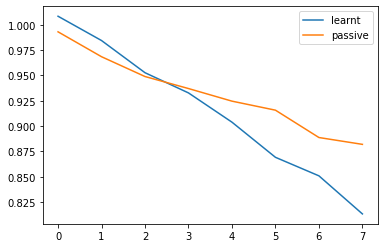

In [71]:
plt.figure()
stop = 8
corr = get_potential_correlation(traj[0:stop])
corr_passive = get_potential_correlation(traj_passive[0:stop])

plt.plot(corr, label='learnt')
plt.plot(corr_passive, label='passive')


# exponential decay fit
pol = np.polyfit(np.arange(len(corr)), np.log(corr), 1)
pol = np.poly1d(pol)
print(-1/pol[1])

pol_passive = np.polyfit(np.arange(len(corr_passive)), np.log(corr_passive), 1)
pol_passive = np.poly1d(pol_passive)
print(-1/pol_passive[1])

# plt.xlim(0, 20)
# plt.yscale('log')
plt.legend()
plt.show()




In [ ]:
# Results:

# Terminal 6x6
# Max speedup: 5x at 6 flips
# k     t_learnt    t_passive   accept_learnt   accept_passive
# 1     16.4        31.4        97%             62%
# 2     8.5         34.1        94.5%           53%
# 4     7.7         25.0        84%             41%
# 6     5.1         24.8        73%             33%
# 8     5.1         26.7        62%             29%
# 10    6.8         23.0        54%             25%
# 12    7.4         26.4        44%             23%
# 16    13.2        25.8        28%             22%

# Continuous 6x6
# Max speedup: 5x at 6 flips
# k     t_learnt    t_passive   accept_learnt   accept_passive
# 1     17.8        49.4        93%             58%
# 2     12.2        30.3        89%             50%
# 4     9.9         42.8        76%             37%
# 6     8.9         46          63%             28%
# 8     14          37          54%             25%

# Discrete 6x6
# Max speedup: 4x at 4 flips
# k     t_learnt    t_passive   accept_learnt   accept_passive
# 1     18.8        47.3        94%             58%
# 2     14.3        50.5        90%             50%
# 4     10.5        44.7        79%             34%
# 6     11.2        48.4        67%             30%
# 8     12.0        39.9        56%             25%

# Terminal 10x10
# Max speedup: 10x at 10 flips
# k     t_learnt    t_passive   accept_learnt   accept_passive
# 1     34.0        50.0        94%             71%
# 6     7.5         30.0        82%             41%
# 10    5.3         32.3        70%             30%
# 12    7.0         35